In [1]:
import piano_reduction.tools as pr
import piano_reduction.compute_features as cf
from piano_reduction.classes import ScoreData, Reduction
from sklearn import metrics
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
reductions = {}
for i, l in tqdm([(a, b) for a in [0, 1, 2, 3, 4] for b in [1, 2, 3, 4, 8, 12, 16, 20, 24]]):
    try:
        reductions['GRU 1 %d %d using cosi_8' % (l, i)] = 'models/20190319l/GRU_1 (%d) (%d) 8.pkl' % (l, i)
    except:
        pass
    try:
        reductions['GRU 2 %d %d using cosi_8' % (l, i)] = 'models/20190319l/GRU_2 (%d) (%d) 8.pkl' % (l, i)
    except:
        pass
    #print(reductions)

100%|██████████| 45/45 [00:00<00:00, 100878.50it/s]


In [3]:
def check_data(name, reds, threshold=0.1, testing_from=0.8, testing_to=0.9):
    _, new_data = ScoreData.load(name).split_in(testing_from, testing_to)
    
    features = ['active_rhythm', 'bass_line', 'entrance_effect', 'highest', 'in_chord', 'lowest', 'occurrence', 
       'onset_after_rest', 'rhythm_variety', 'strong_beats', 'sustained_rhythm', 'vertical_doubling', 'duration_length', 'offset']
    for i in reds:
        if 'GRU' in i:
            new_data = reductions[i].predict(new_data, threshold=threshold, name='y_pred_%s' % i)
        else:
            new_data = reductions[i].predict_2(new_data, threshold=threshold, name='y_pred_%s' % i)
    return new_data

In [14]:
print('%25s\t%20s\t%20s\t%20s' % ('', 'F1 score', 'Accuracy', 'Jaccard Similarity'))
#reds = [i for i in sorted(list(reductions), key=lambda x:(x.split()[1], int(x.split()[2]))) if 'GRU' in i]
from collections import defaultdict
result_l = defaultdict(lambda : [0,0,0])

for M in [1, 2]:
    for L in [1, 2, 3, 4, 8, 12, 16, 20, 24]:
        reductions = {}
        from keras import backend as K
        K.clear_session()
        for I in range(5):
            reductions['GRU %d %d %d using cosi_8' % (M, L, I)] = Reduction.load('models/20190319l/GRU_%d (%d) (%d) 8.pkl' % (M, L, I))
        name = 'score_data/cosi_7.pkl'
        #reds = [i for i in reductions if ('GRU %d %d' % (M, L)) in i]
        #all_data = check_data(name, reds, 0.5)
        tot = [0,0,0]
        for I in range(5):
            i = 'GRU %d %d %d using cosi_8' % (M, L, I)
            all_data = check_data(name, [i], 0.25, I * 0.2, I * 0.2 + 0.2)
            new_data = all_data.copy()
            new_data.df = new_data.df[(new_data.df['x_train'] == 1) | (new_data.df['y_train'] == 1) | (new_data.df['y_pred_%s' % i] == 1)]
            b1 = new_data.to_binary(col='y_train')
            b2 = new_data.to_binary(col='y_pred_%s' % i)
            scores = [metrics.f1_score(new_data.df['y_train'], new_data.df['y_pred_%s' % i]),
                      metrics.accuracy_score(new_data.df['y_train'], new_data.df['y_pred_%s' % i]),
                      pr.jaccard_similarity(b1, b2)
                     ]
            #if 'GRU' in i:
            #    i = '%s using cosi_%c' % (i[2:], i[0])
            #elif 'Attempt 2 both ways' in i:
            #    i = '2 GRU using cosi_%c' % i[0]
            #print('%25s\t%20.9f\t%20.9f\t%20.9f' % tuple([i] + scores))
            tot[0] += scores[0]
            tot[1] += scores[1]
            tot[2] += scores[2]
        print('%25s\t%20.9f\t%20.9f\t%20.9f' % ('GRU %d %d' % (M, L), tot[0] / 5.0, tot[1] / 5.0, tot[2] / 5.0))
        result_l[M, L] = tot
        #print()
        del reductions

                         	            F1 score	            Accuracy	  Jaccard Similarity
                  GRU 1 1	         0.677261355	         0.547652650	         0.517831962
                  GRU 1 2	         0.695135022	         0.593104646	         0.545019104
                  GRU 1 3	         0.699211769	         0.606986577	         0.551213091
                  GRU 1 4	         0.693842195	         0.593584478	         0.546183436
                  GRU 1 8	         0.710412665	         0.612887582	         0.562955157
                 GRU 1 12	         0.710921811	         0.608752553	         0.562719951
                 GRU 1 16	         0.689062499	         0.595370937	         0.537856166
                 GRU 1 20	         0.699417039	         0.605587022	         0.549385433
                 GRU 1 24	         0.705217688	         0.606934670	         0.558086302
                  GRU 2 1	         0.695227219	         0.574922999	         0.541774681
                  GRU

In [15]:
results = """                  GRU 1 1	         0.677261355	         0.547652650	         0.517831962
                  GRU 1 2	         0.695135022	         0.593104646	         0.545019104
                  GRU 1 3	         0.699211769	         0.606986577	         0.551213091
                  GRU 1 4	         0.693842195	         0.593584478	         0.546183436
                  GRU 1 8	         0.710412665	         0.612887582	         0.562955157
                 GRU 1 12	         0.710921811	         0.608752553	         0.562719951
                 GRU 1 16	         0.689062499	         0.595370937	         0.537856166
                 GRU 1 20	         0.699417039	         0.605587022	         0.549385433
                 GRU 1 24	         0.705217688	         0.606934670	         0.558086302
                  GRU 2 1	         0.695227219	         0.574922999	         0.541774681
                  GRU 2 2	         0.710871539	         0.609112759	         0.563378273
                  GRU 2 3	         0.710144089	         0.607228321	         0.562343434
                  GRU 2 4	         0.704442910	         0.604623862	         0.556504135
                  GRU 2 8	         0.701479592	         0.619055886	         0.555974202
                 GRU 2 12	         0.716903485	         0.623050072	         0.572413613
                 GRU 2 16	         0.713305795	         0.610821200	         0.566972499
                 GRU 2 20	         0.702844810	         0.615720105	         0.556642949
                 GRU 2 24	         0.704868744	         0.611090532	         0.557698476"""

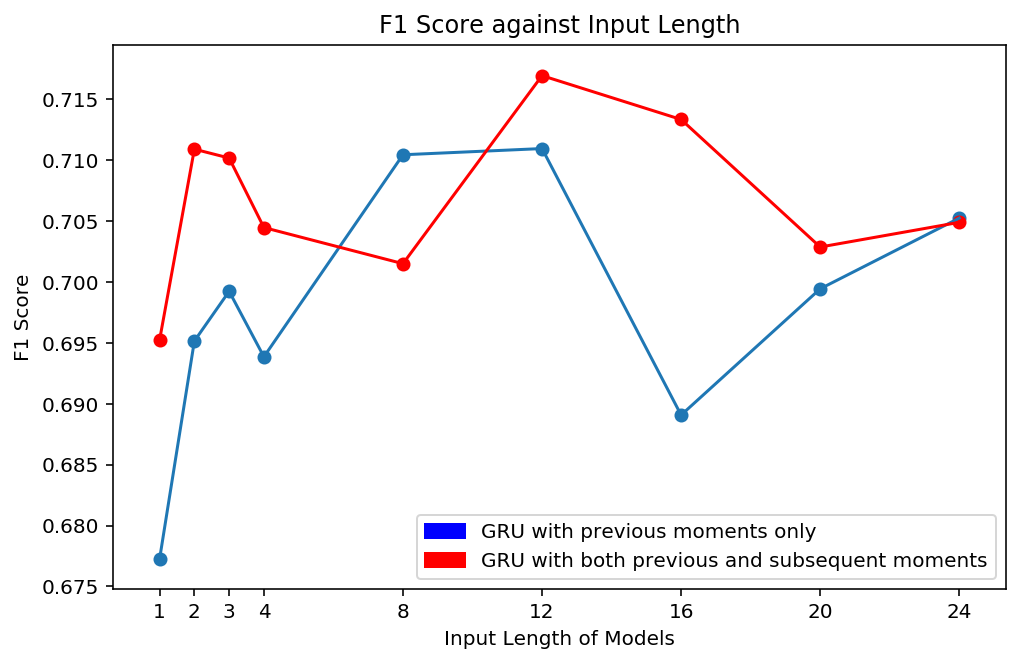

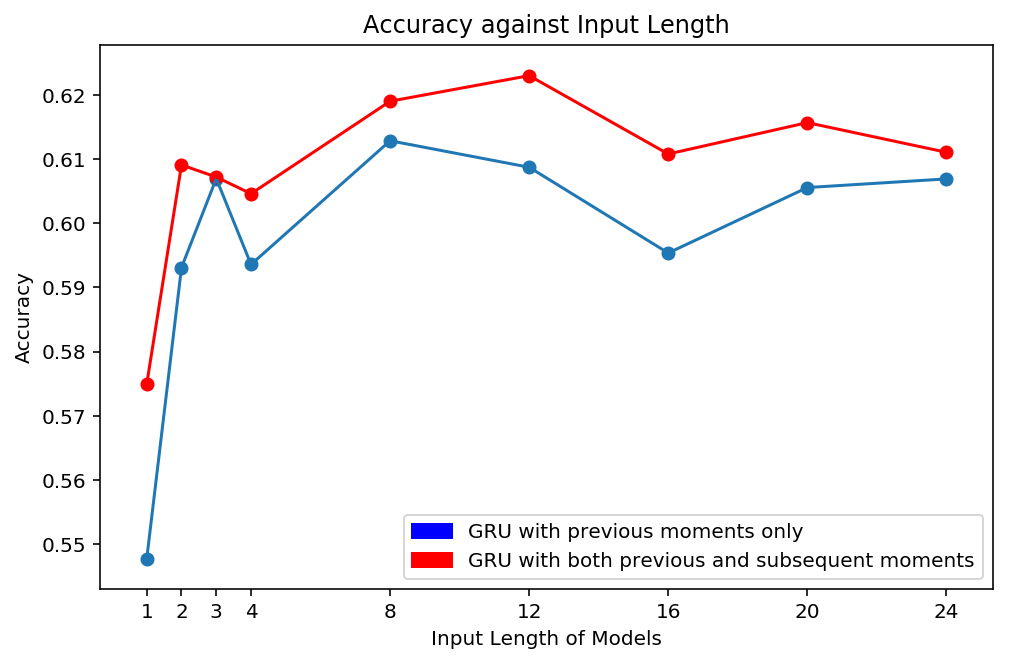

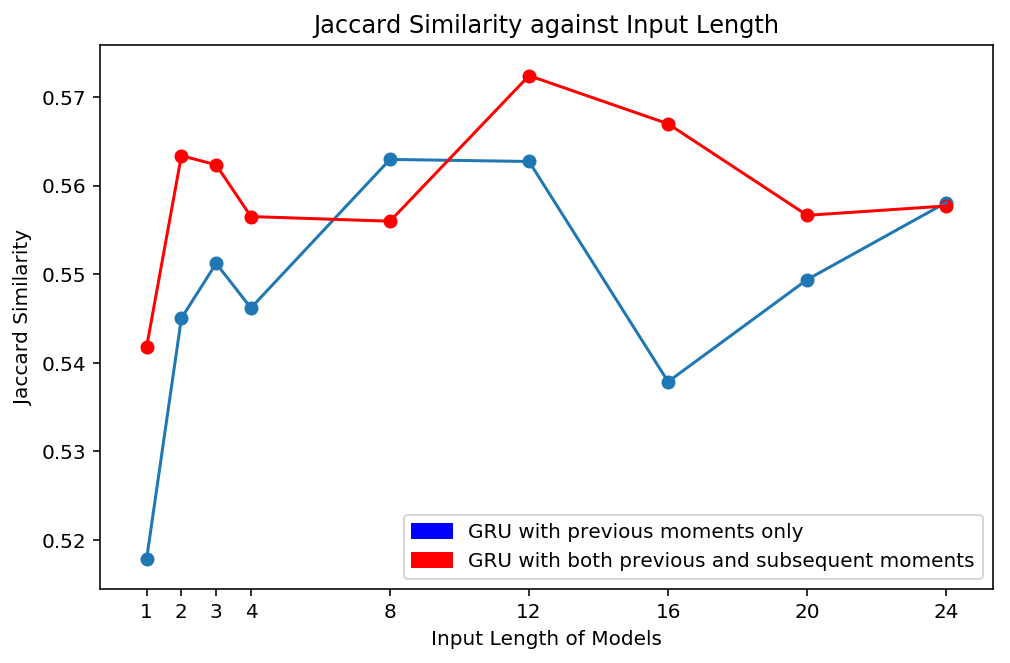

In [16]:
rows = results.split('\n')
rows = list(map(lambda x:x.split('\t'), rows))
for i in range(len(rows)):
    rows[i] = list(map(lambda x:x.strip(), rows[i]))
    rows[i] = [int(rows[i][0].split()[-1])] + list(map(lambda x:float(x), rows[i][1:]))
import numpy as np
rows = np.array([rows[:9], rows[9:]])
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
yl = ['', 'F1 Score', 'Accuracy', 'Jaccard Similarity']
for i in range(1, 4):
    
    plt.figure(figsize=(8,5))
    plt.plot(rows[0,:,0], rows[0,:,i])
    plt.scatter(rows[0,:,0], rows[0,:,i])
    plt.plot(rows[1,:,0], rows[1,:,i],c='r')
    plt.scatter(rows[1,:,0], rows[1,:,i],c='r')
    plt.xlabel('Input Length of Models')
    plt.ylabel(yl[i])
    plt.xticks(rows[0,:,0])
    plt.title('%s against Input Length' % yl[i])
    plt.legend(handles=[mpatches.Patch(color='blue', label='GRU with previous moments only'), mpatches.Patch(color='red', label='GRU with both previous and subsequent moments')])
    plt.show()

In [2]:
reductions = {}
for l in tqdm([1, 2, 3, 4, 8, 12, 16, 20]):
    reductions['GRU with length %d' % (l)] = Reduction.load('models/20190318l/GRU_2 (%d) 8.pkl' % (l))

100%|██████████| 8/8 [00:23<00:00,  3.29s/it]


In [5]:
data = ScoreData.load('score_data/3.pkl')
#data = ScoreData(pr.load_df('fun', 0))
new_data = data.copy()

for i in reductions:
    #if 'GRU 2' not in i or 'cosi_8' not in i:
    #    continue
    new_data = reductions[i].predict(new_data, threshold=0.1, name='y_pred_%s' % i)
    
output_names = []
count = 0
for i in reductions:
    #if 'GRU 2' not in i or 'cosi_8' not in i:
    #    continue
    count += 1
    new_data.df[i] = new_data.df['y_pred_%s' % i]
    output_names.append(i)
new_data.show_score(['x_train'] + output_names)

In [22]:
data = ScoreData.load('score_data/cosi_8.pkl')
data.show_score(['x_train', 'y_train'])

In [53]:
r = Reduction.load('models/20190319l/GRU_%d (%d) (%d) 8.pkl' % (1, 1, 1))

In [54]:
r.params

{'length': 1,
 'features': ['active_rhythm',
  'bass_line',
  'entrance_effect',
  'highest',
  'lowest',
  'occurrence',
  'onset_after_rest',
  'rhythm_variety',
  'strong_beats',
  'sustained_rhythm',
  'vertical_doubling',
  'duration_length']}